## Постановка задачи:

Требуется построить и протестировать классификатор многомерных объектов на основе обучающей выборки - модельные данные и данные из репозитория.
___

## Реализиция: модельные данные

### Построение дискриминантной функции по обучающей выборке, классификация тестовой выборки

Бинарный классификатор должен быть протестирован для двух случаев: хорошо и плохо разделенные данные, распределенные по закону многомерного нормального распределения размерности $p=3$.

Для каждого случая по отдельности должны быть заданы различные векторы средних и равные матрицы ковариаций. Хорошо и плохо разделенные данные будем выбирать, меняя матрицу ковариций.

Хорошо разделенные данные:

ОВ1: $$x \sim N(\mu^{(1)}, \Sigma_{good})$$ ОВ2: $$x \sim N(\mu^{(2)}, \Sigma_{good})$$

Плохо разделенные данные:

ОВ1: $$x \sim N(\mu^{(1)}, \Sigma_{bad})$$ ОВ2: $$x \sim N(\mu^{(2)}, \Sigma_{bad})$$

---

Подключим необходимые для исследования пакеты:

In [3]:
from scipy.stats import multivariate_normal, norm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Зададим размер обучающей выборки $n_1=1000$, $n_2=1000$, векторы средних $m1$ и $m2$, матрицы ковариаций для хорошо и плохо разделимых данных - $s_{good}$ и $s_{bad}$ соответственно.

In [ ]:
n = 2000

m1 = np.array([1, 2, 3])
m2 = np.array([3, 5, -1])

s_good = np.array([[1.2, 0, -1],
              [0, 3, 0.5],
              [-1, 0.5, 4]])
s_bad = (s_good+1.5)*3

q1 = 0.5

Создадим набор необходимых функций для построения классификатора. Для большего удобства функции были "упакованы" в класс **ModelResearch**.

Основной для классификации является функция **calc_estimates**, в ней рассчитываются оценки средниx

$$\mu^{(k)}\to \hat{\mu}^{(k)}, \qquad\ \hat{\mu}^{(k)}_j=\cfrac{1}{n_k}\sum_{i=1}^{n_k} x_{ij},\quad\ k=1,2$$

и оценка матрицы ковариаций

$$S^{(k)}=(s^{(k)}_{lj}),\quad\ l,j=\overline{1,3}, k=1,2$$
$$s^{(k)}_{lj}=\cfrac{1}{n_k-1} \sum_{i=1}^{n_k} (x^{(k)}_{il} - \hat{\mu}^{(k)}_l) (x^{(k)}_{ij}-\hat{\mu}^{(k)}_j), \quad\ k=1,2 $$

$$\Sigma \to S, \qquad\ S=\cfrac{1}{n_1+n_2-2}\lbrack (n_1-1)S^{(1)} + (n_2-1)S^{(2)}\rbrack$$

оценка вектора $\alpha$:

$$\alpha \to \hat{\alpha}=\mathbf{a}, \qquad\ \alpha = \Sigma^{-1}(\mu^{(1)} - \mu^{(2)}) \to \mathbf{a} = S^{-1}(\hat{\mu}^{(1)} - \hat{\mu}^{(2)})$$

а также оценки средних дискриминатной функции

$$\xi_k \to \overline{z}^{(k)}=\langle \hat{\mu}^{(k)}, \mathbf{a} \rangle, \quad\ k=1,2$$

и дисперсии

$$\sigma^2_z \to s^2_z=\sum^{3}_{l=1}\sum^{3}_{j=1}a_l s_{lj} a_j$$

In [ ]:
class ModelResearch():
    def __init__(self, mean1, mean2, cov, q1, size, test_set=None):
        self.sample1 = []
        self.sample2 = []
        self.m1 = mean1
        self.m2 = mean2
        self.cov = cov
        self.q1 = q1
        self.q2 = 1 - q1
        self.n1 = int(size*q1)
        self.n2 = size - self.n1
        self.test_set = test_set        
        
        self.m1_ = []
        self.m2_ = []
        self.cov_ = []
        self.alpha = []
        
        self.mz1_ = 0
        self.mz2_ = 0
        self.z_var = 0
    
    def generate_sample(self):
        self.sample1 = multivariate_normal(mean=self.m1, cov=self.cov).rvs(self.n1, random_state=123)
        self.sample2 = multivariate_normal(mean=self.m2, cov=self.cov).rvs(self.n2, random_state=123)
        
    def calc_estimates(self):
#         samples mean
        self.m1_ = np.mean(self.sample1, axis=0)
        self.m2_ = np.mean(self.sample2, axis=0)        
#         specify covariance matrix for samples
#         assuming that cov1 approximately equal cov2
        self.cov_ = (np.cov(self.sample1.T) + np.cov(self.sample2.T)) / 2
        
        self.alpha = np.linalg.inv(self.cov_) @ (self.m1_-self.m2_)
#         mean of discriminant function
        self.mz1_ = np.dot(self.alpha, self.m1_)
        self.mz2_ = np.dot(self.alpha, self.m2_)
#         variance of discriminant function
        self.z_var = self.alpha @ self.cov_ @ self.alpha

    def makhalanobis(self, unbiased=False):        
        makh = (self.mz1_-self.mz2_)**2 / self.z_var
        if unbiased:
            p = len(self.m1)
            makh = ((self.n1 + self.n2 - p - 3)/
                    (self.n1 + self.n2 - 2)*makh - p*(1/self.n1 + 1/self.n2))**0.5
        return makh
    
    def calc_errors(self, D):
        K = np.log(self.q2 / self.q1)
        F = lambda x: norm.cdf(x)
        return {"p21": F((K - 0.5*D**2)/D), "p12": F((-K - 0.5*D**2)/D)}
    
    def specify_test_set(self, create_new=False):
        if create_new:
            print("Creating test set")
            test1 = multivariate_normal(mean=self.m1, cov=self.cov).rvs(self.n1, random_state=1234)
            test2 = multivariate_normal(mean=self.m2, cov=self.cov).rvs(self.n2, random_state=1234)
        else:
            test1 = self.sample1
            test2 = self.sample2
        self.test_set = np.vstack([test1, test2])
        return np.hstack([np.zeros(self.n1), np.ones(self.n2)])
    
    def predict(self, test_set=None):
        if not test_set:
            test_set = self.test_set
        if test_set is None:
            print("Warning!\n\tTest set not specified!")
            return 
#         (\ksi1 + \ksi2) / 2
        threshold = (self.mz1_ + self.mz2_) / 2
        lnq1q2 = np.log(self.q2 / self.q1)
        threshold += lnq1q2
        predict = []
        for instance in test_set:
            if np.dot(self.alpha, instance) >= threshold:
                predict.append(0)
            else:
                predict.append(1)
        return predict

Создадим классы исследований. Сгенерируем обучающие выборки и тестовые выборки. Размер тестовой выборки $n_т=2000$, выборка содержит равное число элементо из 1 и 2 классов.

In [ ]:
R_good = ModelResearch(m1, m2, s_good, q1, n)
R_bad = ModelResearch(m1, m2, s_bad, q1, n)
R_good.generate_sample()
R_bad.generate_sample()
true_good = R_good.specify_test_set(create_new=True)
true_bad = R_bad.specify_test_set(create_new=True)

Рассчитаем необходимые для классификатора величины.

In [ ]:
R_good.calc_estimates()
R_bad.calc_estimates()

Получим предсказания следующим образом:

Если $$\sum_{j=1}^{p}{a_j x_j} = \langle \mathbf{a}, x \rangle \geq \frac{\overline{z}^{(1)}+\overline{z}^{(2)}}{2} + ln\frac{q_2}{q_1}$$ то относим экземпляр тестовой выборки к 1 классу - иначе к 2 классу.

$q_1$, $q_2$ - отсносительная частота 1 и 2 класса в обучающей выборке. В данном случае $q_1=q_2=0.5$.

In [ ]:
predict_good = R_good.predict()
predict_bad = R_bad.predict()

Рассчитаем эмпирическую вероятность ошибочной классификации:

$$P(1|2) = \frac{m_2}{n_2}$$
$m_2$ - количество элементов 2 класса, которых классификатор определил как 1 класс

$$P(2|1) = \frac{m_1}{n_1}$$
$m_1$ - количество элементов 1 класса, которых классификатор определил как 2 класс

И построим четырехпольную таблицу сопряженности.

In [ ]:
cm_good = confusion_matrix(true_good, predict_good)
cm_bad = confusion_matrix(true_bad, predict_bad)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(cm_good, display_labels=["1", "2"]).plot(ax=ax[0])
ax[0].set_title("Хорошо разделенные данные")
ConfusionMatrixDisplay(cm_bad, display_labels=["1", "2"]).plot(ax=ax[1])
ax[1].set_title("Плохо разделенные данные")
fig.tight_layout()

_, m21, m12, _ = cm_good.ravel()
print(f"Хорошо разделенные данные: \n\tP(1|2) = {m12 / R_good.n2}, P(2|1) = {m21 / R_good.n1}")

_, m21, m12, _ = cm_bad.ravel()
print(f"Плохо разделенные данные: \n\tP(1|2) = {m12 / R_bad.n2}, P(2|1) = {m21 / R_bad.n1}")

### Исследование классификации исходной обучающей выборки

Укажем тестовую выборку (без аргумента *create_new=True* в методе **specify_test_set()** в качестве классифицируемых указываются исходные обучающие выборки)

In [ ]:
true_good = R_good.specify_test_set()
true_bad = R_bad.specify_test_set()
predict_good = R_good.predict()
predict_bad = R_bad.predict()

Рассчитаем оценки вероятностей ошибочной классификации:

$$\hat{P}(1|2) = \frac{m_2}{n_2}$$
$m_2$ - количество элементов 2 класса, которых классификатор определил как 1 класс

$$\hat{P}(2|1) = \frac{m_1}{n_1}$$
$m_1$ - количество элементов 1 класса, которых классификатор определил как 2 класс

И построим четырехпольную таблицу сопряженности.

In [ ]:
cm_good = confusion_matrix(true_good, predict_good)
cm_bad = confusion_matrix(true_bad, predict_bad)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ConfusionMatrixDisplay(cm_good, display_labels=["1", "2"]).plot(ax=ax[0])
ax[0].set_title("Хорошо разделенные данные")
ConfusionMatrixDisplay(cm_bad, display_labels=["1", "2"]).plot(ax=ax[1])
ax[1].set_title("Плохо разделенные данные")
fig.tight_layout()

_, m21, m12, _ = cm_good.ravel()
print(f"Хорошо разделенные данные: \n\tP(1|2) = {m12 / R_good.n2}, P(2|1) = {m21 / R_good.n1}")

_, m21, m12, _ = cm_bad.ravel()
print(f"Плохо разделенные данные: \n\tP(1|2) = {m12 / R_bad.n2}, P(2|1) = {m21 / R_bad.n1}")

Получим несмещенную оценку расстояния Махаланобиса:

$$D^2_н = \frac{n_1+n_2-p-3}{n_1+n_2-2}D^2-p(\frac{1}{n_1}+\frac{1}{n_2}), \quad\ p=3$$

гдe $$D^2 = \frac{(\overline{z}^{(1)} - \overline{z}^{(2)})^2}{s_z^2}$$

И оценки вероятностей ошибочной классификации:

$$\hat{P}(2|1) = Ф\Bigg(\cfrac{K-\frac{1}{2}D_н^2}{D_н}\Bigg) $$

$$\hat{P}(1|2) = Ф\Bigg(\cfrac{-K-\frac{1}{2}D_н^2}{D_н}\Bigg)$$

$$Ф(y)=\cfrac{1}{\sqrt{2\pi}}\int\limits_{-\infty}^{y}e^{-\frac{t^2}{2}}dt$$

$$K=ln\bigg( \cfrac{q_2 c(1|2)}{q_1 c(2|1)} \bigg)$$

Где $c(1|2), c(2|1)$ - стоимости ошибочной классификации

В нашем случае $q_1=q_2=0.5$, а $c(1|2)=c(2|1)$ так как задача не предполагает выделения важности конкретной ошибки. Следовательно $K=0$.

In [ ]:
print("Хорошо разделенные данные:")
makh_good = R_good.makhalanobis(unbiased=True)
errors = R_good.calc_errors(makh_good)
print(f"\tРасстояние Махаланобиса: {round(makh_good, 3)}",)
print(f"\tОценки ошибочной классификации: P(2|1) = {round(errors['p21'], 3)}\t P(1|2) = {round(errors['p12'], 3)}")
print()
print("Плохо разделенные данные:")
makh_bad = R_bad.makhalanobis(unbiased=True)
errors = R_bad.calc_errors(makh_bad)
print(f"\tРасстояние Махаланобиса: {round(makh_bad, 3)}")
print(f"\tОценки ошибочной классификации: P(2|1) = {round(errors['p21'], 3)}\t P(1|2) = {round(errors['p12'], 3)}")

Заметим, что и для тестовой выборки, и для обучающих данных, классикация хорошо разделенных данных получается качественнее - эмипирическая вероятность ошибочной классификации и ее оценка в обоих случаях ниже нежели в случае плохо разделенных данных.

Что и требовалось ожидать - расстояние Махалонобиса и оценки вероятностей ошибочной классификации больше в случае плохо разделенных данных

## Реализация: данные из репозитория

---

### Построение дискриминантной функции по обучающей выборке, классификация тестовой выборки

In [1]:
class RepoResearch:
    def __init__(self, x, y, train_coef):
        logging = True
        self.X = x
        self.Y = y
        
        self.sample1 = self.X[self.Y == 1]
        self.sample2 = self.X[self.Y == 2]
        
        size1 = len(self.sample1)
        size2 = len(self.sample2)
        if logging:
            print(f"First: {size1}, second: {size2}")
            
        self.train1 = self.sample1[:int(train_coef*size1)]
        self.train2 = self.sample2[:int(train_coef*size2)]
        self.train_trueY = np.hstack([np.ones(len(self.train1)), np.full(len(self.train2), 2)])
        self.train_set = np.vstack([self.train1, self.train2])
        self.train_n1 = len(self.train1)
        self.train_n2 = len(self.train2)
        
        self.test1 = self.sample1[int(train_coef*size1):]
        self.test2 = self.sample2[int(train_coef*size2):]
        # true targets
        self.test_trueY = np.hstack([np.ones(len(self.test1)), np.full(len(self.test2), 2)])
        self.test_set = np.vstack([self.test1, self.test2])
        self.test_n1 = len(self.test1)
        self.test_n2 = len(self.test2)
        
        if logging:
            print(f"Train: 1: {len(self.train1)}, 2: {len(self.train2)}")
            print(f"Test: 1: {len(self.test1)}, 2: {len(self.test2)}")
        
        self.q1 = len(self.train1) / (len(self.train1) + len(self.train2))
        self.q2 = 1-self.q1
        
        if logging:
            print(f"q1 = {self.q1}, q2 = {self.q2}")
        
    def calc_estimates(self):
#         samples mean
        self.m1_ = np.mean(self.train1, axis=0)
        self.m2_ = np.mean(self.train2, axis=0)
        
#         specify covariance matrix for samples
#         assuming that cov1 approximately equal cov2
        self.cov_ = ((len(self.train1)-1)*np.cov(self.train1.T) + (len(self.train2)-1)*np.cov(self.train2.T)) / (len(self.train1) + len(self.train2) - 2)
        
        self.alpha = np.linalg.inv(self.cov_) @ (self.m1_-self.m2_)
#         mean of discriminant function
        self.mz1_ = np.dot(self.alpha, self.m1_)
        self.mz2_ = np.dot(self.alpha, self.m2_)
#         variance of discriminant function
        self.z_var = self.alpha @ self.cov_ @ self.alpha
    
    def makhalanobis(self, unbiased=False):        
        makh = (self.mz1_-self.mz2_)**2 / self.z_var
        if unbiased:
            p = len(self.m1_)
            n1 = self.train_n1
            n2 = self.train_n2
            makh = ((n1 + n2 - p - 3) / (n1 + n2 - 2)*makh - p*(1/n1 + 1/n2))**0.5
        return makh
    
    def calc_errors(self, D):
        K = np.log(self.q2 / self.q1)
        F = lambda x: norm.cdf(x)
        return {"p21": F((K - 0.5*D**2)/D), "p12": F((-K - 0.5*D**2)/D)}
    
        
    def predict(self, predict_test_set=True):
        if predict_test_set:
            predict_set = self.test_set
        else:
            predict_set = self.train_set
#         (\ksi1 + \ksi2) / 2
        threshold = (self.mz1_ + self.mz2_) / 2
        lnq1q2 = np.log(self.q2 / self.q1)
        threshold += lnq1q2
        predict = []
        for instance in predict_set:
            if np.dot(self.alpha, instance) >= threshold:
                predict.append(1)
            else:
                predict.append(2)
        return predict
        

In [22]:
X = []
Y = []
with open("german.data-numeric") as data:
    for string in data:
        string = string.split()
        x, y = string[:-1], string[-1]
        X.append(np.array(list(map(lambda elem: float(elem), x))))
        Y.append(int(y))
X = np.array(X)
Y = np.array(Y)

repo_research = RepoResearch(X, Y, 0.9)
repo_research.calc_estimates()


First: 700, second: 300
Train: 1: 630, 2: 270
Test: 1: 70, 2: 30
q1 = 0.7, q2 = 0.30000000000000004


Эмпирические вероятности ошибочной классификации: 
	P(1|2) = 0.367, P(2|1) = 0.114


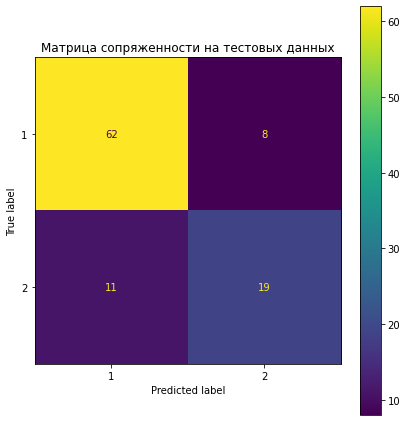

In [23]:
predict = repo_research.predict(predict_test_set=True)

cm = confusion_matrix(repo_research.test_trueY, predict)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ConfusionMatrixDisplay(cm, display_labels=["1", "2"]).plot(ax=ax)
ax.set_title("Матрица сопряженности на тестовых данных")
fig.tight_layout()

_, m21, m12, _ = cm.ravel()
print(f"Эмпирические вероятности ошибочной классификации: \n\tP(1|2) = {round(m12 / repo_research.test_n2, 3)}, P(2|1) = {round(m21 / repo_research.test_n1, 3)}")

Оценки вероятностей ошибочной классификации: 
	P(1|2) = 0.47, P(2|1) = 0.114


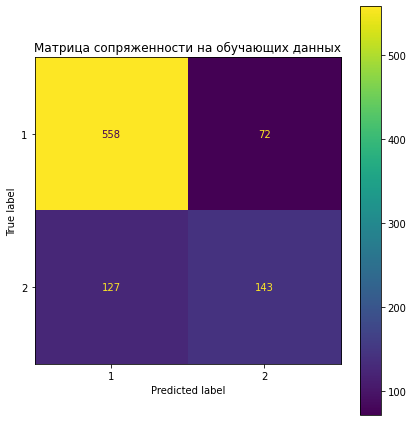

In [24]:
predict = repo_research.predict(predict_test_set=False)

cm = confusion_matrix(repo_research.train_trueY, predict)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ConfusionMatrixDisplay(cm, display_labels=["1", "2"]).plot(ax=ax)
ax.set_title("Матрица сопряженности на обучающих данных")
fig.tight_layout()

_, m21, m12, _ = cm.ravel()
print(f"Оценки вероятностей ошибочной классификации: \n\tP(1|2) = {round(m12 / repo_research.train_n2, 3)}, P(2|1) = {round(m21 / repo_research.train_n1, 3)}")

In [244]:
makh = repo_research.makhalanobis(unbiased=True)
errors = repo_research.calc_errors(makh)
print(f"\tРасстояние Махаланобиса: {round(makh, 3)}")
print(f"\tОценки ошибочной классификации: P(1|2) = {round(errors['p12'], 3)} \t P(2|1) = {round(errors['p21'], 3)}")


	Расстояние Махаланобиса: 1.198
	Оценки ошибочной классификации: P(1|2) = 0.543 	 P(2|1) = 0.096


In [220]:
X = []
Y = []
with open("german.data-numeric") as data:
    for string in data:
        string = string.split()
        x, y = string[:-1], string[-1]
        X.append(np.array(list(map(lambda elem: float(elem), x))))
        Y.append(int(y))
X = np.array(X)
Y = np.array(Y)

mean = np.mean(X, axis=0)
covariance = np.cov(X.T)
X_centered = X - mean
# X_stand = X_centered
# X_stand = X

X_stand = X_centered / np.sqrt(np.diagonal(covariance))

covariance = np.cov(X_stand.T)


# print(np.diagonal(covariance))
# print(mean)
# print(covariance)

harmonic_number = lambda i, N: sum(map(lambda x: 1/x, range(i, N+1))) / N

eiges = np.linalg.eig(covariance)

values, vectors = eiges
print(sorted(values))
eiges = sorted(list(zip(values, vectors.T)), key=lambda x: x[0], reverse=True)

val_mean = np.mean(values)
normer = sum(values)
otbor = values[values>val_mean]
print('По правилу Кайзера: ', len(otbor), otbor, '\n')

size = len(values)

trost = list(filter(lambda x: x[1] / normer > harmonic_number(x[0], size), zip(range(1, size+1), values)))
print('По правилу сломанной трости: ', len(trost), trost)

print(np.trace(covariance))
great_vals = values[values > 1]
print(f"{len(great_vals)}: {great_vals}")



[0.15874153711288633, 0.19971701119594854, 0.3134856014227221, 0.34111931231335124, 0.4986048928085151, 0.564554728495974, 0.6073869976775683, 0.6464332838976344, 0.7035193075808213, 0.7830943271579911, 0.8282149737749901, 0.860556678945047, 0.8898541814481615, 0.9464527905680706, 1.0105446317266957, 1.1214697322455403, 1.1597061906477908, 1.2152100601527107, 1.3214752099004294, 1.6321735680921894, 1.7039787259068833, 1.85393991601479, 2.1214765908001927, 2.5182897501131256]
По правилу Кайзера:  10 [2.51828975 2.12147659 1.85393992 1.70397873 1.63217357 1.32147521
 1.21521006 1.15970619 1.12146973 1.01054463] 

По правилу сломанной трости:  14 [(8, 1.3214752099004294), (11, 1.2152100601527107), (12, 1.1597061906477908), (13, 1.1214697322455403), (15, 0.564554728495974), (16, 0.6073869976775683), (17, 0.6464332838976344), (18, 0.7035193075808213), (19, 1.0105446317266957), (20, 0.9464527905680706), (21, 0.7830943271579911), (22, 0.8282149737749901), (23, 0.8898541814481615), (24, 0.8605

In [237]:
# print(X[:3])
# X_centered = X - mean
# X_stand = X / np.sqrt(np.diagonal(covariance))
transform_ = np.vstack(list([eiges[i][1] for i in range(10)]))
X_new = X_stand @ transform_.T + mean @ transform_.T
# print(X_centered[:3])

In [238]:
print(mean @ transform_.T)

[ 27.26398732 -13.04659315 -11.44741732 -17.23932215  -4.80834173
   2.52072292  -1.59722678  -0.52908614   6.48095802 -14.12494639]


In [239]:
repo_research_PCA = RepoResearch(X_new, Y, 0.9)
repo_research_PCA.calc_estimates()

First: 700, second: 300
Train: 1: 630, 2: 270
Test: 1: 70, 2: 30
q1 = 0.7, q2 = 0.30000000000000004


Эмпирические вероятности ошибочной классификации: 
	P(1|2) = 0.433, P(2|1) = 0.143


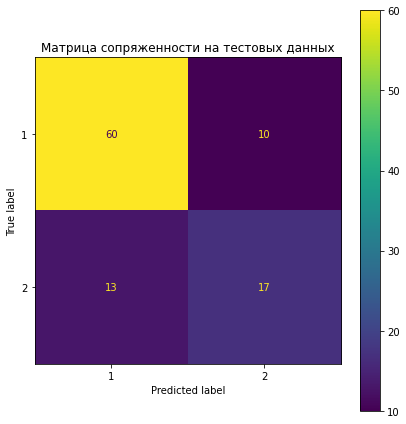

In [243]:
predict = repo_research_PCA.predict(predict_test_set=True)

cm = confusion_matrix(repo_research_PCA.test_trueY, predict)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ConfusionMatrixDisplay(cm, display_labels=["1", "2"]).plot(ax=ax)
ax.set_title("Матрица сопряженности на тестовых данных")
fig.tight_layout()

_, m21, m12, _ = cm.ravel()
print(f"Эмпирические вероятности ошибочной классификации: \n\tP(1|2) = {round(m12 / repo_research_PCA.test_n2, 3)}, P(2|1) = {round(m21 / repo_research_PCA.test_n1, 3)}")

Оценки вероятностей ошибочной классификации: 
	P(1|2) = 0.526, P(2|1) = 0.098


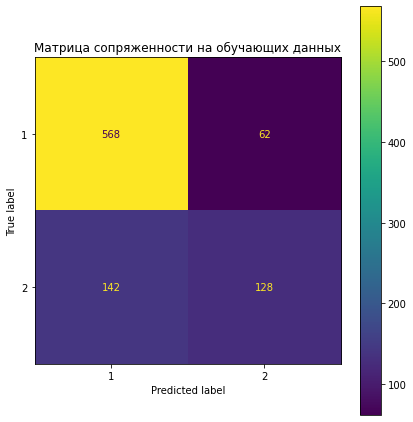

In [242]:
predict = repo_research_PCA.predict(predict_test_set=False)

cm = confusion_matrix(repo_research_PCA.train_trueY, predict)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ConfusionMatrixDisplay(cm, display_labels=["1", "2"]).plot(ax=ax)
ax.set_title("Матрица сопряженности на обучающих данных")
fig.tight_layout()

_, m21, m12, _ = cm.ravel()
print(f"Оценки вероятностей ошибочной классификации: \n\tP(1|2) = {round(m12 / repo_research_PCA.train_n2, 3)}, P(2|1) = {round(m21 / repo_research_PCA.train_n1, 3)}")

In [245]:
makh = repo_research_PCA.makhalanobis(unbiased=True)
errors = repo_research_PCA.calc_errors(makh)
print(f"\tРасстояние Махаланобиса: {round(makh, 3)}")
print(f"\tОценки ошибочной классификации: P(1|2) = {round(errors['p12'], 3)} \t P(2|1) = {round(errors['p21'], 3)}")

	Расстояние Махаланобиса: 1.14
	Оценки ошибочной классификации: P(1|2) = 0.569 	 P(2|1) = 0.095


In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
XPCAreduced = pca.fit_transform(X)

print(XP)

repo_research_PCA_2 = RepoResearch(XPCAreduced, Y, 0.8)
repo_research_PCA_2.calc_estimates()

predict = repo_research_PCA_2.predict(predict_test_set=True)

print(len(predict))
print(len(repo_research_PCA_2.test_trueY))

First: 700, second: 300
Train: 1: 560, 2: 240
Test: 1: 140, 2: 60
q1 = 0.7, q2 = 0.30000000000000004
200
200


Эмпирические вероятности ошибочной классификации: 
	P(1|2) = 0.883, P(2|1) = 0.021


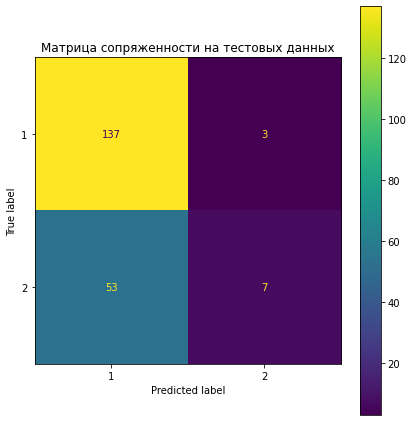

In [11]:
cm = confusion_matrix(repo_research_PCA_2.test_trueY, predict)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ConfusionMatrixDisplay(cm, display_labels=["1", "2"]).plot(ax=ax)
ax.set_title("Матрица сопряженности на тестовых данных")
fig.tight_layout()

_, m21, m12, _ = cm.ravel()
print(f"Эмпирические вероятности ошибочной классификации: \n\tP(1|2) = {round(m12 / repo_research_PCA_2.test_n2, 3)}, P(2|1) = {round(m21 / repo_research_PCA_2.test_n1, 3)}")

In [ ]:
h = 10

| True\Predict | 1  | 2  |
| :---:        | :---: | :----: |
| 1    | {{h}} | 283    |
| 2   | {{h}} | 283    |

$\gamma=10$

$$\alpha=12$$